# Lecture 3: Advanced Numerical Integration

## Summary
- Integration Methods
    - Newton-Cotes limitations & errors
    - Optimization of integration points
        -  Chebyshev nodes & polynomials
            - Clenshaw-Curtis integration method
        -  Legendre nodes & polynomials
            - Gauss - Legendre integration method

In [3]:
import numpy as np
import numpy.linalg as npl
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import time
%matplotlib inline

Create CLenshaw-Curtis and Gauss-Legendre methods

In [4]:
# create clenshaw-curtis method
def gauss_legendre(f, n):
    ''' 
        f: a function of x
        n: degree of interpolation polynomial 

        I: integration approximation of f(x)
        w: weight
        x: clenshaw-curtis nodes
    '''

    n = float(n)
    na = np.arange(1, n+1, 1) # (n+1)-pt Gauss quadrature of f
    beta = .5 / np.sqrt(1 - ((2 * na)**(-2))) # 3-term recurrence coeffs
    T = np.diag(beta, 1) + np.diag(beta, -1) # Jacobi matrix
    [x, V] = npl.eig(T) # eigenvalue decomposition
    i = np.argsort(x); x = np.sort(x) # nodes (= Legendre points)
    w = 2 * V[0,i]**2 # weights
    I = np.dot(w, f(x)) # the integral
    return I, w, x

# create gauss-legendre method 
def clenshaw_curtis(f, n):
    '''
        f: separate function of x
        n: degree of interpolation polynomial used to approximate integration
    
        I: integration approximation of f(x)
        w: weight
        x: legendre nodes
    '''
    
    n = float(n)
    na = np.arange(0, n+1, 1)
    x = np.cos(np.pi*na/n) # Chebyshev points
    fx = f(x) / (2 * n)
    ind_1 = np.arange(0, n+1, 1, dtype=int)
    ind_2 = np.arange(n-1 , 0, -1, dtype=int)
    ind = np.concatenate((ind_1, ind_2))
    g = np.real(np.fft.fft(fx[ind])); # Fast Fourier Transform (FFT)
    a = g[1:int(n)] + g[2*int(n)-1:int(n):-1] # Chebyshev coefficients  
    a = np.insert(a, [0, len(a)], [g[0], g[int(n)]]) # Chebyshev coefficients           
    w = np.zeros(len(a)); ii = np.arange(0, n+1, 2); w[::2] = 2 / (1 - ii**2);
    I = np.dot(w, a) # find integral
    return I, w, x

# create font
font = {'family':'monospace', 'color':'black', 'size':13} # set font dictionary

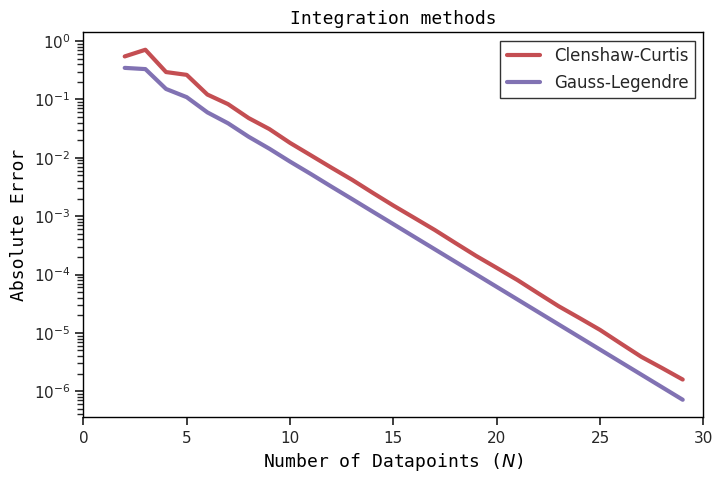

In [6]:
# create function f(x)
def f(x):
    return 1 / (1 + 16 * x **2)

# set max number of nodes
N = 30

# analytical solution for f(x)
sol = np.arctan(4) / 2 

# allocate memory for error
err_cc = np.zeros(N)
err_g = np.zeros(N)

for k in range(2, N):
    err_cc[k] = abs(clenshaw_curtis(f, k-1)[0] - sol)
    err_g[k] = abs(gauss_legendre(f, k-1)[0] - sol)

# plot errors
plt.figure(figsize=(8,5))
plt.semilogy(range(2,N), err_cc[2::], 'r-', label='Clenshaw-Curtis', lw=3)
plt.semilogy(range(2,N), err_g[2::], 'm-', label='Gauss-Legendre', lw=3)
plt.xlim((0,N))

# format graph
plt.title('Integration methods', fontdict=font)
plt.xlabel('Number of Datapoints ($N$)', fontdict=font)
plt.ylabel('Absolute Error', fontdict=font)
plt.legend(loc='best', prop={'size':12})

plt.rcParams.update({
                    "legend.facecolor" : 'white',
                    "font.family" : "DejaVu Sans",
                    "xtick.bottom" : True,
                    "ytick.left" : True,
                    "legend.edgecolor" : 'black',
                    "legend.fancybox" : False,
                    'axes.facecolor' : 'white',
                    'legend.edgecolor' : 'black',
                    'xtick.labelsize' : 11,
                    'ytick.labelsize' : 11,
                    'axes.labelsize' : 13,
                    'axes.grid' : False,
                    'axes.edgecolor' : 'black',
                    'axes.linewidth': 1
                     })

**Example.** We want to compute the following

$$
\int_{-1}^1 x^{20} dx
$$

numerically with both Clenshaw-Curtis and Gauss-Legendre methods. In Python:

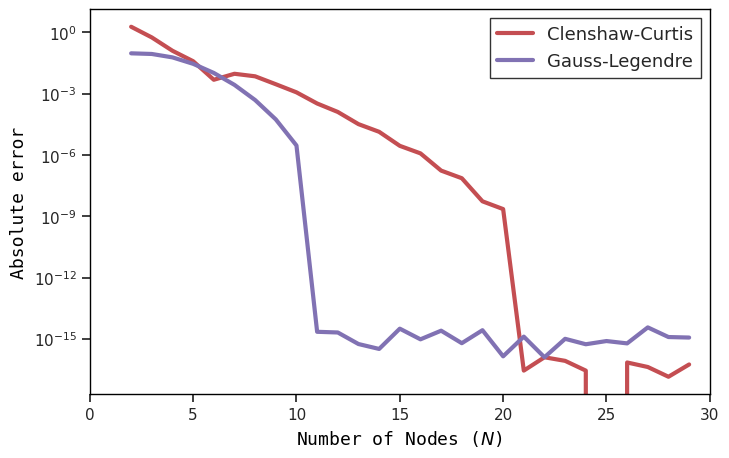

In [16]:
def func(x):
    return x**(20)

sol_an = 2 / 21 # analytical solution

# set max number of nodes
N = 30

Err_cc = np.zeros(N); Err_g = np.zeros(N);

for k in range(2, N):
    Err_cc[k] = abs(clenshaw_curtis(func, k-1)[0]-sol_an)
    Err_g[k] = abs(gauss_legendre(func, k-1)[0]-sol_an)

# plot absolute errors
plt.figure(figsize=(8, 5))
plt.semilogy(range(2,N), Err_cc[2::], 'r-', label='Clenshaw-Curtis', lw=3)
plt.semilogy(range(2,N), Err_g[2::], 'm-', label='Gauss-Legendre', lw=3)

plt.xlabel('Number of Nodes ($N$)', fontsize=13, fontdict=font)
plt.ylabel('Absolute error', fontdict=font);
plt.legend(fontsize=13)
plt.xlim((0, N));

Clenshaw-Curtis requires more interpolation points to reach the same accuracy as the Gauss-Legendre method. Clenshaw-Curtis as exact for methods up to degree $n$ whereas Gauss-Legendre exact up to degree $2n+1$.

Compare the time taken for each method by computing the time needed for approximating an integral $P_M(x)$ i.e. a polynomial of degree $M$ as a function of $M$.

In [18]:
# find time taken for each method
Mmax = 2000 # set max polynomial degree (M)
r = np.arange(3, Mmax, 50); # create array of polynomial orders to test

# create empty array to store time
tfg = np.zeros(len(r)) # gauss method
tfc = np.zeros(len(r)) # clenshaw method
con = 0

for k in r:

    # find approximation for every polynomial degree
    t = time.time()
    I = gauss_legendre(func, (k+1)/2-1)[0]
    tfg[con] = time.time() - t
    
    # find approximation for every polynomial degree
    t = time.time()
    I = clenshaw_curtis(func, k)[0]
    tfc[con] = time.time() - t
    con+=1

Text(0, 0.5, 'Time ($s$)')

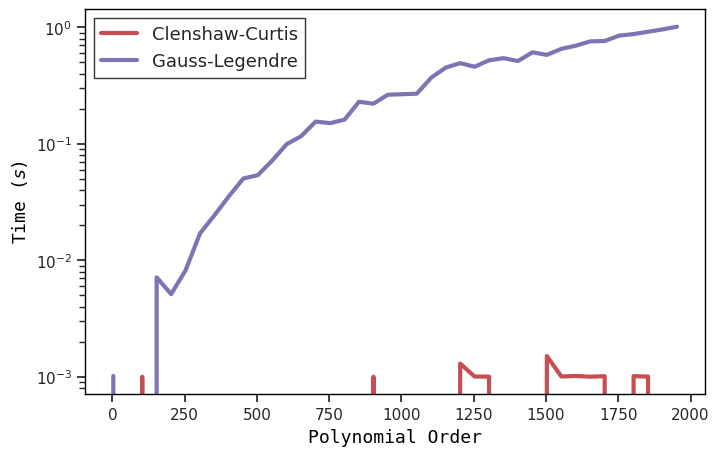

In [25]:
# plot graphs
plt.figure(figsize=(8,5))
plt.semilogy(r, tfc, 'r', label='Clenshaw-Curtis', lw=3)
plt.semilogy(r, tfg, 'm', label='Gauss-Legendre', lw=3)
plt.legend(loc='best', fontsize=13)
plt.xlabel('Polynomial Order', fontdict=font)
plt.ylabel('Time ($s$)', fontdict=font)